---

<h1> <center> ProjectOAK </center> </h1>  

<h3> <center> By Sam Evans and Maria Yampolskaya </center> </h3>

---

###Colab notebook stuff

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec 15 13:58:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ProjectOAK/ProjectOAK-main
!ls
!unzip "/content/drive/MyDrive/ProjectOAK/ProjectOAK-main/data.zip" -d "/content"

### Import libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import time
import csv
import glob
import os #to check if model weights exist.
from os import path

import tensorflow as tf
from tensorflow.keras import layers, models

try:
    import QOL.plots as pqol #custom plotting stuff for Sam
    pqol.fixfigsize((1,1))
    pqol.scale_fonts((2,2))
except:
    print('pqol not loaded, defaulting to matplotlib.pyplot.')
    pqol=plt

import ImageProcessing as ip #ProjectOAK file with image processing functions.
import  DataProcessing as dp #ProjectOAK file with data  processing functions.
import  ScrapedLoading as sl #ProjectOAK file with functions for loading data from bulba-scraped dataset
''' #comment this line while developing the ProjectOAK files above; this will force reloads of the files when runnign this cell.
from importlib import reload 
reload(ip)
reload(dp)
reload(sl)
#''';

pqol not loaded, defaulting to matplotlib.pyplot.
pqol not loaded, defaulting to matplotlib.pyplot.
pqol not loaded, defaulting to matplotlib.pyplot.


In [42]:
# a few helper functions for N-hot vectors

def make_Nhot(type1, type2):
  ''' given strings type1 and type2 (type2 can be empty), return a one-hot vector'''
  vec = np.zeros(len(dp.ALLTYPES)-1) # ignore the empty type at the end
  vec[dp.ALLTYPES.index(type1)] = 1
  if type2 != '':
    vec[dp.ALLTYPES.index(type2)] = 1
  return vec

def Nhot_to_names(vec):
  ''' given an N-hot vector, return an array of strings of type names '''
  types = np.array([])
  for index in np.where(vec == 1)[0]:
    if index >= len(dp.ALLTYPES):
      print("Warning! 1 found at " + str(index))
      print('\n Vector: ' + str(vec))
    types = np.append(types, dp.ALLTYPES[index])
  return types

def prediction_to_names(vec, threshold):
  ''' given an array of prediction probabilities, return an array of strings
      of the two mostly likely types (the second type probability will only be
      included if it is above the threshold probability) '''
  types = np.array([])
  sorted = np.sort(vec)
  largest1 = sorted[-1]
  largest2 = sorted[-2]
  
  types = np.append(types, dp.ALLTYPES[np.where(vec == largest1)[0][0]])
  if largest2 >= threshold:
    types = np.append(types, dp.ALLTYPES[np.where(vec == largest2)[0][0]])
    
  return types

In [6]:
#whether to show examples throughout notebook. If False, hide most examples, for brevity.
SHOW_EXAMPLES = True#@param {type:"boolean"}
Ntypes = dp.NTYPES             #number of types; probably 18; could be less if using "metatypes".

---
<h2> <center> Load the Pokémon Data! </center> </h2>  

---

In [7]:
try:
  del metadata
  del poke_added
  print('Re-creating metadata')
except:
  print("Creating metadata for the first time")

# first create a dict with empty lists
metadata = {'paths': [], 'labels': []}
poke_added = [] # make sure we don't add duplicates or mega types

# now fill the lists
with open(r'./dataset/Pokedex_Ver6.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      if (path.exists(r'/content/scraped_cleaned_200/%s' %row['NAME'])
         and row['NUMBER'] not in poke_added):
        for file in glob.glob(r'/content/scraped_cleaned_200/%s/*' %row['NAME']):
          metadata['paths'] += [file]
          if (row['TYPE2'] != ''):
            metadata['labels'] += [[row['TYPE1'], row['TYPE2']]]
          else:
            metadata['labels'] += [[row['TYPE1']]]
          # print(row['NUMBER'])
        poke_added += [row['NUMBER']]

print("Found " + str(len(poke_added)) + " Pokemon")

Creating metadata for the first time
Found 879 Pokemon


In [8]:
image_metadata = pd.DataFrame(metadata)
print(f'Found {len(image_metadata)} images')

image_metadata.sample(3)

Found 5117 images


,paths,labels
4241,/content/scraped_cleaned_200/Furfrou/152-HOME6...,[Normal]
2782,/content/scraped_cleaned_200/Luxray/053-405Lux...,[Electric]
681,/content/scraped_cleaned_200/Geodude/001-074Ge...,"[Rock, Ground]"


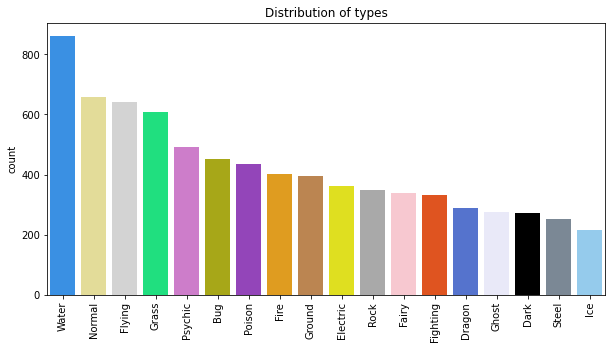

In [123]:
from collections import Counter

if SHOW_EXAMPLES:
  colors = ['dodgerblue', 'khaki', 'lightgrey', 'springgreen', 'orchid',
            'y', 'darkorchid', 'orange', 'peru', 'yellow', 'darkgrey', 'pink',
            'orangered', 'royalblue', 'lavender', 'black', 'lightslategrey', 'lightskyblue']

  all_types = [label for lbs in image_metadata['labels'] for label in lbs]
  labels_count = Counter(all_types)
  plt.figure(figsize=(10,5))
  ax = sb.countplot(x=all_types, order=[k for k, _ in labels_count.most_common()],
                    log=False, palette=colors)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  plt.title('Distribution of types')
  plt.show()

### Set Up Data Augmentation

In [67]:
image_augment = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    rescale=1/255.,
    rotation_range=20,       #rotate by up to this many degrees.
    width_shift_range=0.1,   #shift by up to this fraction of the image, horizontally.
    height_shift_range=0.1,  #shift by up to this fraction of the image, vertically.
    # vertical_flip=True,      #whether to sometimes flip images vertically.
    horizontal_flip=True,    #whether to sometimes flip images horizontally.
    zoom_range=0.1,          #zoom random within [0.8 .. 1.2]
    shear_range=0.1,         #range for shear transformations
    fill_mode='constant',
    cval=0
)

params = {'dataframe': image_metadata,
          'shuffle': True,
          'x_col': 'paths',
          'y_col': 'labels',
          'class_mode': 'categorical',
          'batch_size': 64,
          'color_mode': 'rgba',
          'target_size': (200,200)}

training_generator = image_augment.flow_from_dataframe(
    subset='training',
    **params
)

validation_generator = image_augment.flow_from_dataframe(
    subset='validation',
    **params
)


Found 4094 validated image filenames belonging to 18 classes.
Found 1023 validated image filenames belonging to 18 classes.


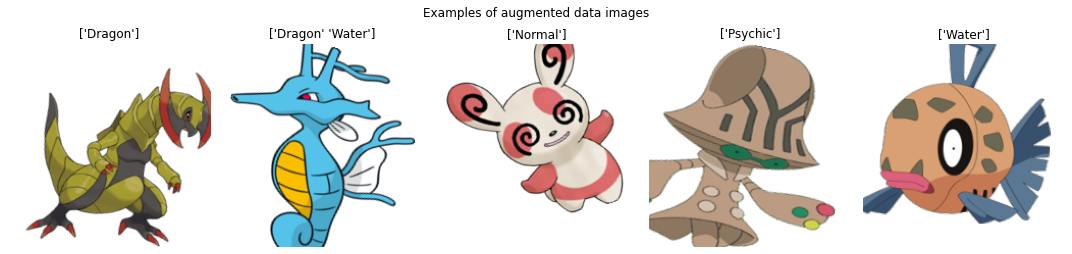

In [83]:
if SHOW_EXAMPLES:
    B = 5
    ims, lbs = next(training_generator)
    fig, axs = plt.subplots(1, B, figsize=(3*B,4))
    plt.suptitle('Examples of augmented data images')
    for i in range(B):
        plt.sca(axs[i])
        plt.imshow(ims[i])
        plt.axis('off')
        plt.title(str(Nhot_to_names(lbs[i])))
    plt.tight_layout()
    plt.show()

---
<h2> <center> A Wild Neural Network Appears! </center> </h2>  

---

### Define Network Architecture

In [84]:
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
num_classes = dp.NTYPES
IMAGESHAPE = (200,200,4)

def create_CNN():
    model = models.Sequential()

    model.add(layers.GaussianNoise(0.1, input_shape = IMAGESHAPE))

    model.add(layers.Conv2D(16, 3,
                            activation='relu',
                            padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size = (2,2)))
    
    model.add(layers.Conv2D(8, 5,
                            activation='relu',
                            padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size = (2,2)))

    model.add(layers.Conv2D(4, 5,
                            activation='relu',
                            padding = 'same'))
    model.add(layers.GaussianNoise(0.05))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = 'selu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(num_classes, activation = 'sigmoid'))
    
    # compile the model
    model.compile(loss= SigmoidFocalCrossEntropy(), #'binary_crossentropy'
                  optimizer=tf.keras.optimizers.Nadam(),
                  metrics=[tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
                           tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2'),
                           tf.keras.metrics.TopKCategoricalAccuracy(k=4, name='top4')])

    
    return model

In [85]:
model = create_CNN()

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_5 (GaussianNo (None, 200, 200, 4)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 200, 200, 16)      592       
_________________________________________________________________
batch_normalization_16 (Batc (None, 200, 200, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 8)       3208      
_________________________________________________________________
batch_normalization_17 (Batc (None, 100, 100, 8)       32        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 8)        

### Train the Network

In [86]:
from tqdm.keras import TqdmCallback

epochs = 200
verbose = 0

history = model.fit(training_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    verbose=verbose,
                    callbacks=[TqdmCallback(data_size=4094, batch_size=64, verbose=1)])

In [87]:
# save the model?
save = True #@param {type:"boolean"}
if save:
  model.save('/content/drive/MyDrive/ProjectOAK/ProjectOAK-main/models/200epochs')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProjectOAK/ProjectOAK-main/models/200epochs/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProjectOAK/ProjectOAK-main/models/200epochs/assets


### Check network performance vs epoch

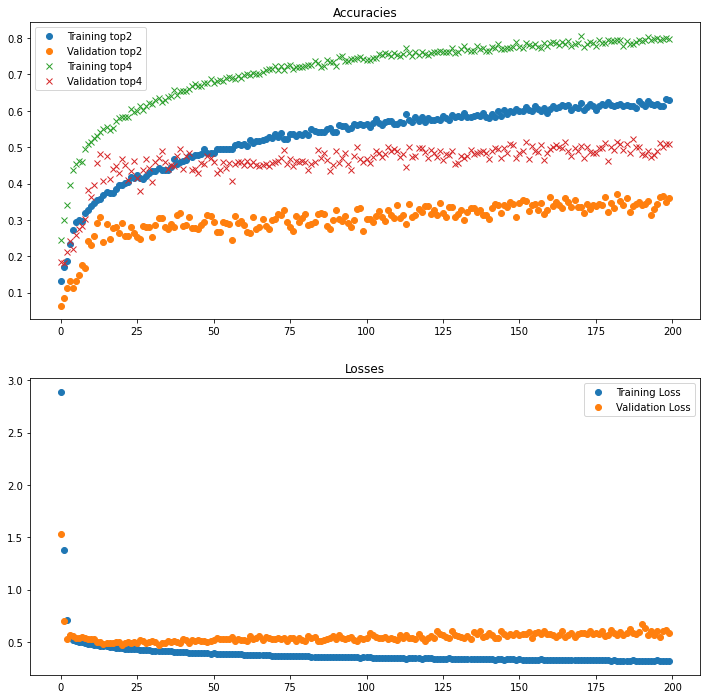

Maximum validation accuracy achieved: 0.37243402004241943


In [118]:
show_histories = 1
accstr = 'top2'
accstr2 = 'top4'

if show_histories:
    epochs = len(history.history['loss'])

    plt.figure(figsize=(12, 12))
    plt.subplot(2, 1, 1)
    plt.plot(range(epochs), history.history[accstr], 'o', label='Training '+accstr)
    plt.plot(range(epochs), history.history['val_'+accstr], 'o', label='Validation '+accstr)
    if accstr2 is not None:
        plt.plot(range(epochs), history.history[accstr2], 'x', label='Training '+accstr2)
        plt.plot(range(epochs), history.history['val_'+accstr2], 'x', label='Validation '+accstr2)
    plt.legend()
    plt.title('Accuracies')

    plt.subplot(2, 1, 2)
    plt.plot(range(epochs), history.history['loss'], 'o', label='Training Loss')
    plt.plot(range(epochs), history.history['val_loss'], 'o', label='Validation Loss')
    plt.legend()
    plt.title('Losses')
    plt.show()

    print("Maximum validation accuracy achieved: " + str(np.max(history.history['val_'+accstr])))

### Check predictions of model

In [94]:
import math

number_of_examples = len(validation_generator.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 64)) 

val_labels = []
val_images = []

for i in range(0,int(number_of_generator_calls)):
    val_labels.extend(np.array(validation_generator[i][1]))
    val_images.extend(validation_generator[i][0])

True types (validation data)


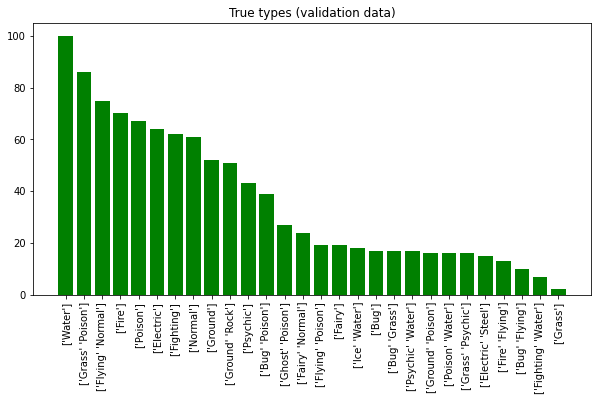

Predicted types (validation data)


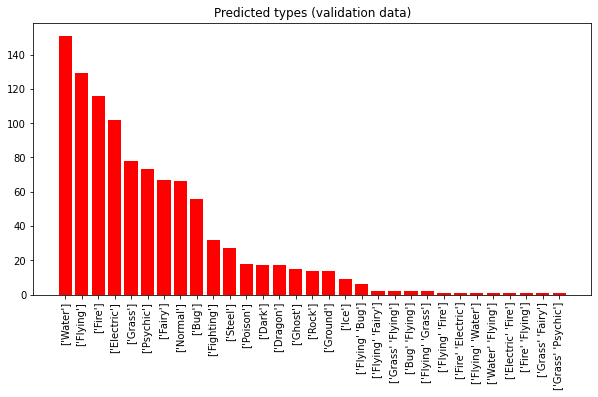

In [105]:
## show distribution of predicted types & distribution of types in the validation dataset

from collections import Counter, OrderedDict

val_names = [str(Nhot_to_names(label)) for label in val_labels]
val_counted = OrderedDict(Counter(val_names).most_common())

predicted = model.predict(validation_generator)
pred_names = [str(prediction_to_names(label, 0.5)) for label in predicted]
pred_counted = OrderedDict(Counter(pred_names).most_common())

print("True types (validation data)")
plt.figure(figsize=(10,5))
plt.title("True types (validation data)")
plt.bar(val_counted.keys(), val_counted.values(), color='g')
plt.xticks(rotation='vertical')
plt.show()

print("Predicted types (validation data)")
plt.figure(figsize=(10,5))
plt.title("Predicted types (validation data)")
plt.bar(pred_counted.keys(), pred_counted.values(), color='r')
plt.xticks(rotation='vertical')
plt.show()

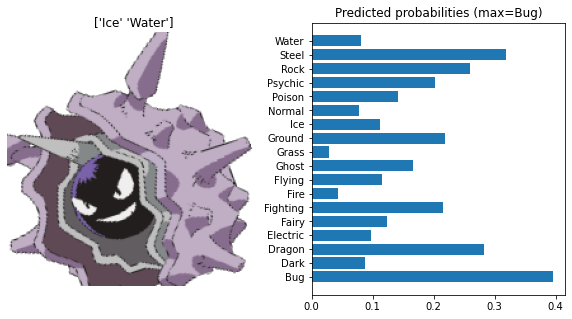

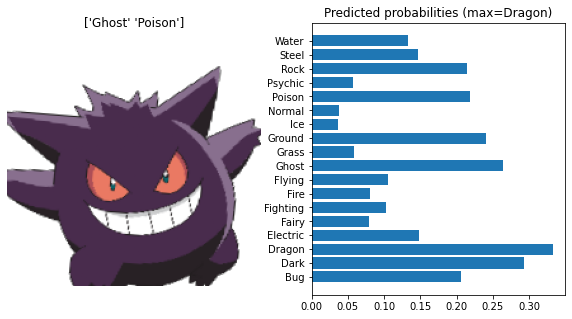

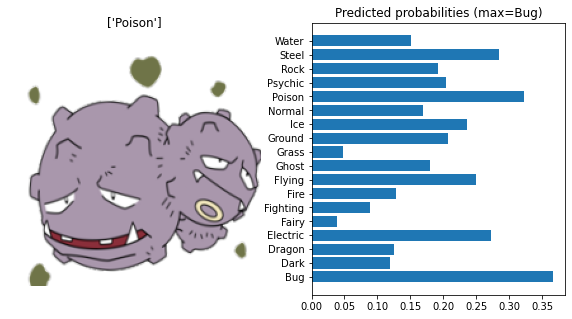

In [117]:
## plot prediction probabilities for some of the pokemon in the test set
NSAMPLES = 3

imgs, lbls = next(validation_generator)
predictions = model.predict(imgs)

for i in range(NSAMPLES):
    fig, axs = plt.subplots(1, 2, figsize=[10, 5])
    plt.sca(axs[0])
    plt.imshow(imgs[i])
    arr = np.array(lbls[i])
    index = np.where(arr == 1)

    plt.title(str(Nhot_to_names(lbls[i])))
    plt.axis("off")

    plt.sca(axs[1])
    plt.title("Predicted probabilities (max="+str(dp.idx_to_type(dp.prediction_to_idx(predictions[i]))) + ")")
    plt.barh(dp.ALLTYPES[:-1], predictions[i])
    
    # plt.sca(axs[2])
    # plt.title("log Probabilities")
    # plt.barh(dp.ALLTYPES[:-1], predictions[i])
    # plt.xscale('log')
  
    # plt.tight_layout()
    plt.show()
    


### Talos hyperparameter tuning

In [ ]:
!pip install talos

In [ ]:
def talos_model(train_x, train_y, val_x, val_y, params):
    num_classes = dp.NTYPES

    model = models.Sequential()

    model.add(layers.GaussianNoise(params['noise'], input_shape = IMAGESHAPE))

    model.add(layers.Conv2D(8, 3,
                            activation='relu',
                            padding = 'same'))
    model.add(layers.LayerNormalization())
    model.add(layers.AveragePooling2D(pool_size = (2,2)))
    
    model.add(layers.Conv2D(4, 5,
                            activation='relu',
                            padding = 'same'))
    model.add(layers.LayerNormalization())
    model.add(layers.MaxPooling2D(pool_size = (2,2)))
    model.add(layers.GaussianNoise(0.1))

    model.add(layers.Conv2D(2, 5,
                            activation='relu',
                            padding = 'same'))
    model.add(layers.LayerNormalization())
    model.add(layers.MaxPooling2D(pool_size = (2,2)))
    model.add(layers.GaussianNoise(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(params['last_neuron'], activation = params['last_activation']))
    model.add(layers.LayerNormalization())
    model.add(layers.Dropout(params['last_dropout']))
    
    model.add(layers.Dense(num_classes, activation = 'sigmoid'))
    
    # compile the model
    model.compile(loss=SigmoidFocalCrossEntropy(),
                  optimizer=Nadam(params['lr']),
                  metrics=[tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
                           tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3')])
    
    epochs = 10
    batch_size = 32
    verbose = 0
    
    history = model.fit(datagen.flow(train_x, train_y, batch_size=batch_size),
                    validation_data=(datagen_val.flow(val_x, val_y)),
                    steps_per_epoch=len(sdd.train_data) / batch_size,
                    epochs=epochs,
                    verbose=verbose)

    return history, model

In [ ]:
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow_addons.losses import SigmoidFocalCrossEntropy

p = {'noise': [0.1, 0.2],
     'last_neuron': [32, 64],
     'last_dropout': [0.05, 0.1],
     'last_activation': ['relu', 'selu', 'sigmoid'],
     'lr': [0.0001, 0.001]
     }

In [ ]:
import talos

scan_object = talos.Scan(x=sdd.train_data, y=sdd.train_labels,
                         x_val=sdd.val_data, y_val=sdd.val_labels, 
                         params=p,
                         model=talos_model,
                         experiment_name='initial',
                         print_params=True)


  0%|          | 0/48 [00:00<?, ?it/s]

{'last_activation': 'relu', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.1}



  2%|▏         | 1/48 [00:36<28:42, 36.65s/it]

{'last_activation': 'relu', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.2}



  4%|▍         | 2/48 [01:12<28:01, 36.56s/it]

{'last_activation': 'relu', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.1}



  6%|▋         | 3/48 [01:49<27:29, 36.66s/it]

{'last_activation': 'relu', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.2}



  8%|▊         | 4/48 [02:26<26:50, 36.60s/it]

{'last_activation': 'relu', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.1}



 10%|█         | 5/48 [03:02<26:13, 36.58s/it]

{'last_activation': 'relu', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.2}



 12%|█▎        | 6/48 [03:39<25:37, 36.60s/it]

{'last_activation': 'relu', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.1}



 15%|█▍        | 7/48 [04:16<25:00, 36.60s/it]

{'last_activation': 'relu', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.2}



 17%|█▋        | 8/48 [04:52<24:25, 36.63s/it]

{'last_activation': 'relu', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.1}



 19%|█▉        | 9/48 [05:29<23:46, 36.59s/it]

{'last_activation': 'relu', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.2}



 21%|██        | 10/48 [06:05<23:11, 36.61s/it]

{'last_activation': 'relu', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.1}



 23%|██▎       | 11/48 [06:42<22:36, 36.67s/it]

{'last_activation': 'relu', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.2}



 25%|██▌       | 12/48 [07:19<22:00, 36.67s/it]

{'last_activation': 'relu', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.1}



 27%|██▋       | 13/48 [07:56<21:24, 36.69s/it]

{'last_activation': 'relu', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.2}



 29%|██▉       | 14/48 [08:32<20:46, 36.65s/it]

{'last_activation': 'relu', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.1}



 31%|███▏      | 15/48 [09:09<20:08, 36.63s/it]

{'last_activation': 'relu', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.2}



 33%|███▎      | 16/48 [09:45<19:31, 36.60s/it]

{'last_activation': 'selu', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.1}



 35%|███▌      | 17/48 [10:22<18:54, 36.61s/it]

{'last_activation': 'selu', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.2}



 38%|███▊      | 18/48 [10:59<18:19, 36.65s/it]

{'last_activation': 'selu', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.1}



 40%|███▉      | 19/48 [11:35<17:43, 36.68s/it]

{'last_activation': 'selu', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.2}



 42%|████▏     | 20/48 [12:12<17:08, 36.73s/it]

{'last_activation': 'selu', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.1}



 44%|████▍     | 21/48 [12:49<16:32, 36.77s/it]

{'last_activation': 'selu', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.2}



 46%|████▌     | 22/48 [13:26<15:54, 36.70s/it]

{'last_activation': 'selu', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.1}



 48%|████▊     | 23/48 [14:02<15:17, 36.70s/it]

{'last_activation': 'selu', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.2}



 50%|█████     | 24/48 [14:39<14:40, 36.69s/it]

{'last_activation': 'selu', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.1}



 52%|█████▏    | 25/48 [15:16<14:04, 36.70s/it]

{'last_activation': 'selu', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.2}



 54%|█████▍    | 26/48 [15:53<13:27, 36.70s/it]

{'last_activation': 'selu', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.1}



 56%|█████▋    | 27/48 [16:29<12:50, 36.68s/it]

{'last_activation': 'selu', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.2}



 58%|█████▊    | 28/48 [17:06<12:15, 36.79s/it]

{'last_activation': 'selu', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.1}



 60%|██████    | 29/48 [17:43<11:38, 36.74s/it]

{'last_activation': 'selu', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.2}



 62%|██████▎   | 30/48 [18:20<11:01, 36.77s/it]

{'last_activation': 'selu', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.1}



 65%|██████▍   | 31/48 [18:56<10:24, 36.71s/it]

{'last_activation': 'selu', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.2}



 67%|██████▋   | 32/48 [19:33<09:47, 36.71s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.1}



 69%|██████▉   | 33/48 [20:09<09:09, 36.65s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.2}



 71%|███████   | 34/48 [20:46<08:33, 36.68s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.1}



 73%|███████▎  | 35/48 [21:23<07:56, 36.66s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.05, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.2}



 75%|███████▌  | 36/48 [22:00<07:20, 36.67s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.1}



 77%|███████▋  | 37/48 [22:36<06:44, 36.73s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.2}



 79%|███████▉  | 38/48 [23:13<06:07, 36.72s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.1}



 81%|████████▏ | 39/48 [23:50<05:30, 36.71s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.05, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.2}



 83%|████████▎ | 40/48 [24:27<04:53, 36.71s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.1}



 85%|████████▌ | 41/48 [25:03<04:16, 36.70s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.0001, 'noise': 0.2}



 88%|████████▊ | 42/48 [25:40<03:39, 36.66s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.1}



 90%|████████▉ | 43/48 [26:16<03:03, 36.64s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.1, 'last_neuron': 32, 'lr': 0.001, 'noise': 0.2}



 92%|█████████▏| 44/48 [26:53<02:26, 36.66s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.1}



 94%|█████████▍| 45/48 [27:30<01:50, 36.74s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.0001, 'noise': 0.2}



 96%|█████████▌| 46/48 [28:07<01:13, 36.71s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.1}



 98%|█████████▊| 47/48 [28:43<00:36, 36.70s/it]

{'last_activation': 'sigmoid', 'last_dropout': 0.1, 'last_neuron': 64, 'lr': 0.001, 'noise': 0.2}



100%|██████████| 48/48 [29:20<00:00, 36.67s/it]


In [ ]:
# scan_object.data.head()
sorted = scan_object.data.sort_values('val_top3', ascending=False)

In [ ]:
sorted.head()

,start,end,duration,round_epochs,loss,pr_auc,top3,val_loss,val_pr_auc,val_top3,last_activation,last_dropout,last_neuron,lr,noise
26,12/10/20-213427,12/10/20-213503,36.400435,10,0.523765,0.104099,0.226525,0.488258,0.111871,0.249169,selu,0.10,32,0.0010,0.1
0,12/10/20-211834,12/10/20-211910,36.397324,10,0.644968,0.083244,0.180058,0.706537,0.114006,0.239203,relu,0.05,32,0.0001,0.1
39,12/10/20-214224,12/10/20-214300,36.472278,10,0.515622,0.103506,0.204259,0.509427,0.102802,0.235880,sigmoid,0.05,64,0.0010,0.2
22,12/10/20-213200,12/10/20-213236,36.449226,10,0.514121,0.100261,0.214908,0.555903,0.099520,0.235880,selu,0.05,64,0.0010,0.1
23,12/10/20-213236,12/10/20-213313,36.406666,10,0.516822,0.099804,0.220716,0.500461,0.105520,0.222591,selu,0.05,64,0.0010,0.2


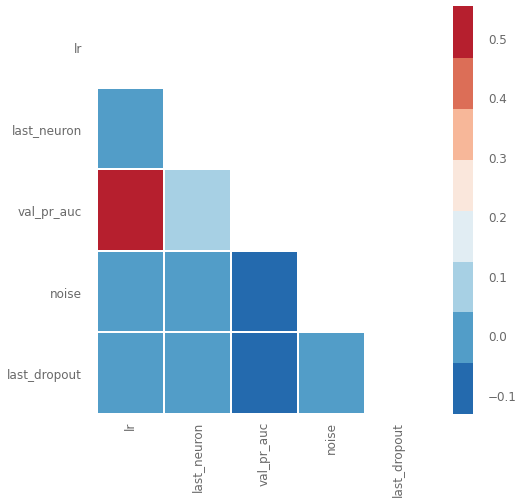

In [ ]:
def scanned_p(p, return_dict=False):
    '''returns parameters (keys) from p (a dict) which have len(p[key])>1.
    if return_dict, returns the dict of parameters p[key] for key in result.
    '''
    r = []
    for key in p.keys():
        try:
            if len(p[key])>1: r+=[key]
        except:
            pass
    return r if not return_dict else {key:p[key] for key in sorted(r)}

def unscanned_cols(t, p=p):
    '''returns column names for columns which are not scanned parameters.'''
    sp = scanned_p(p, return_dict=False)
    return [c for c in t.data.columns if not c in sp]

exclude=unscanned_cols(scan_object,p)

analyze_object = talos.Analyze(scan_object)
analyze_object.plot_corr('val_pr_auc', exclude)

## Classifying by dominant color: a toy model
For many Pokemon, it's easy to visually identify the type by the dominant color. For example, many grass-type Pokemon are green. Let's see how well a toy model can do if it only takes the dominant color as input.

In [ ]:
## First we need a function to find the dominant color

import binascii
import scipy
import scipy.misc
import scipy.cluster

def find_dominant_color(image, show):
  ''' use K-Means clustering to find the most common color(s)
      adapted from https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image'''  

  if show:
    plt.imshow(image)
    plt.axis("off")

  ar = np.asarray(image)
  shape = ar.shape
  ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
  nonwhite = []

  for color in ar:
    if (color != [255., 255., 255.]).all():
      nonwhite.append(color)

  NUM_CLUSTERS = 4
  codes, dist = scipy.cluster.vq.kmeans(nonwhite, NUM_CLUSTERS)

  vecs, dist = scipy.cluster.vq.vq(nonwhite, codes)         # assign codes
  counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

  index_max = scipy.argmax(counts)                    # find most frequent
  peak = codes[index_max]
  return peak
  # colour = binascii.hexlify(bytearray(int(c) for c in peak)).decode('ascii')
  # print('most frequent is %s (#%s)' % (peak, colour))

In [ ]:
image_colors = np.array([find_dominant_color(image,False) for image in used_images_compiled])

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(image_colors, Nhot_labels_compiled, test_size = 0.3)

### Now we define our simple neural network

In [ ]:
def baby_model():
    num_classes = dp.NTYPES

    model = models.Sequential()

    model.add(layers.Dense(18, activation = 'relu', input_dim = 3))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(num_classes, activation = 'sigmoid'))
    
    # compile the model
    model.compile(loss=SigmoidFocalCrossEntropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.AUC(curve="PR", name="pr_auc"),
                           tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top1'),
                           tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3'),
                           'binary_accuracy'])

    
    return model

In [ ]:
babby = baby_model()
# babby.summary()

In [ ]:
epochs = 20
batch_size = 32
verbose = 0

babby_history = babby.fit(x=x_train, y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    verbose=verbose)

print("Maximum validation accuracy achieved: " + str(np.max(babby_history.history['val_top1'])))

Maximum validation accuracy achieved: 0.44144144654273987


Let's look at an example case and see how well the toy model performs

['Water']


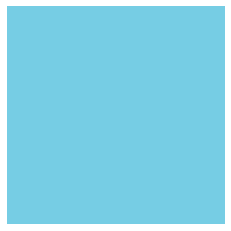

<BarContainer object of 18 artists>

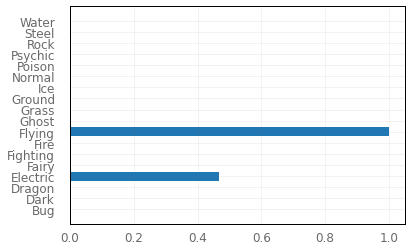

In [ ]:
clrs = x_test[0:20]
predictions = babby.predict(clrs)

ind = 13

print(Nhot_to_names(y_test[ind]))

length = 10
color = np.array(clrs[ind])/255.
patch = np.full((length,length,3), color)

plt.imshow(patch)
plt.axis("off")
plt.show()

plt.barh(dp.ALLTYPES[:-1], predictions[0])
plt.show()

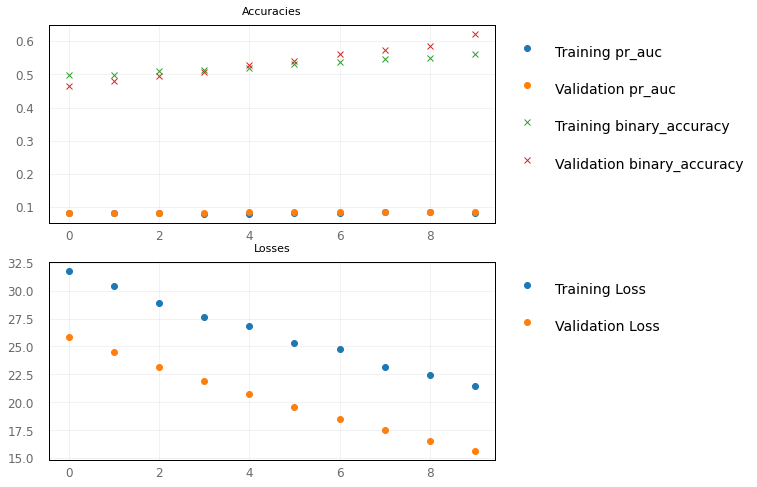

Maximum validation accuracy achieved: 0.6218718886375427


In [ ]:
show_histories = 1
accstr = 'pr_auc'
accstr2 = 'binary_accuracy'

if show_histories:
    epochs = len(babby_history.history['loss'])

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(range(epochs), babby_history.history[accstr], 'o', label='Training '+accstr)
    plt.plot(range(epochs), babby_history.history['val_'+accstr], 'o', label='Validation '+accstr)
    if accstr2 is not None:
        plt.plot(range(epochs), babby_history.history[accstr2], 'x', label='Training '+accstr2)
        plt.plot(range(epochs), babby_history.history['val_'+accstr2], 'x', label='Validation '+accstr2)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title('Accuracies')

    plt.subplot(2, 1, 2)
    plt.plot(range(epochs), babby_history.history['loss'], 'o', label='Training Loss')
    plt.plot(range(epochs), babby_history.history['val_loss'], 'o', label='Validation Loss')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title('Losses')
    plt.show()

    print("Maximum validation accuracy achieved: " + str(np.max(babby_history.history['val_'+accstr2])))